## Gradient Boosting Classifier
This notebook defines the python script corresponding to the non-DL scenario. The multinomial classifier I used is the **XGB** implementation which supports the GPU acceleration

In [35]:
# load training set
import pandas as pd
import numpy as np

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_stemmed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('c:/Users/I051796/Projects/CES/data/label.csv', sep=';')

##  Data Preparation

In [36]:
# vectorize the text with TF-IDF transform
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

vectorizer = TfidfVectorizer(strip_accents='ascii')
XTFIDFVectorizedTrain = vectorizer.fit_transform(XTrain['question'])
XTFIDFVectorizedTrain = pd.DataFrame(XTFIDFVectorizedTrain.toarray())
XTFIDFVectorizedTrain.head(2)

,0,1,2,3,4,5,6,7,8,9,...,7228,7229,7230,7231,7232,7233,7234,7235,7236,7237
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# perform a dimensional reduction into 600 dimensional space
# use the same dimensionality than the one provided by fasttext embedding model in the DL context
from sklearn.decomposition import PCA

PCATransform = PCA(n_components=600)
PCAXTrain = pd.DataFrame(PCATransform.fit_transform(XTFIDFVectorizedTrain))

In [38]:
from sklearn.model_selection import train_test_split
# combine input features from above text vectorization with text characteristics features (../../data/staging_data/text_extracted_features.csv)
extractedFeatures = pd.read_csv('../../data/staging_data/text_extracted_features.csv', sep=',')
mergedXTrain = PCAXTrain.join(extractedFeatures, lsuffix='', rsuffix='')

# split into train and test
mergedXTrain, mergedXTest, YTrain, YTest = train_test_split(mergedXTrain, YTrain, test_size=0.15, random_state=42)

mergedXTrain.head(5)

,0,1,2,3,4,5,6,7,8,9,...,likelihood_topic_41,likelihood_topic_42,likelihood_topic_43,likelihood_topic_44,likelihood_topic_45,likelihood_topic_46,likelihood_topic_47,likelihood_topic_48,likelihood_topic_49,likelihood_topic_50
1188,-0.067848,0.137391,-0.052612,0.054141,-0.006294,0.072978,0.023330,-0.046059,-0.041962,0.037868,...,0.02,0.00,0.04,0.0,0.10,0.04,0.02,0.04,0.04,0.02
4252,-0.063017,-0.024779,0.053789,-0.032791,0.124255,0.045154,-0.046089,-0.032632,-0.111669,0.011124,...,0.02,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
447,-0.046234,0.086332,0.044161,-0.012975,0.031441,0.190497,0.021634,-0.160032,-0.140722,0.021131,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.02,0.00
2926,-0.070371,0.080047,-0.029866,-0.013008,-0.002458,0.054223,-0.056180,-0.020208,-0.005981,-0.105799,...,0.02,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3733,0.102780,-0.073656,-0.131044,-0.082372,-0.022838,-0.016694,0.072906,-0.035320,-0.005377,0.003573,...,0.00,0.02,0.00,0.0,0.02,0.00,0.00,0.00,0.00,0.02


## Hyper-parameter Search

In [39]:
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# run a grid search with key parameter value candidates
# max_depth
# min_child_weight
# n_estimators
# early stopping
# learning_rate (eta)

# turn to True in order to trigger the greedy hyper param search
if False:
    grid_parameters = {
        'max_depth':[4,6,8],
        "min_child_weight" :[2,5,10],
        "learning_rate" :[0.05,0.1]
    }

    gbm = xgb.XGBClassifier(
        objective = "multi:softprob",
        n_estimators=100,
        eval_metric ="mlogloss",
        n_jobs=2,    
        tree_method='gpu_hist',
        n_gpus=1)

    gridSearch = GridSearchCV(
        estimator=gbm,
        fit_params = None,
        param_grid = grid_parameters,
        cv=4,
        verbose=1)

    gridSearch.fit(mergedXTrain, YTrain.intention)
    print(gridSearch.best_estimator)    
    pd.DataFrame(gridSearch.cv_results_['mean_test_score']).plot(figsize=(15,10))

Grid search indicates that below parameters give the best accuracy:

* min_child_weight=10
* max_depth=8
* learning_rate=0.1


## Fit final model

In [40]:
import xgboost as xgb

gbm = xgb.XGBClassifier(
    min_child_weight=10,
    max_depth=8,
    learning_rate=0.1,
    objective = "multi:softprob",
    n_estimators=100,
    eval_metric ="mlogloss",
    n_jobs=2,
    tree_method='gpu_hist',
    n_gpus=1)


gbm.fit(mergedXTrain, YTrain.intention, early_stopping_rounds=10, eval_set=[(mergedXTrain,YTrain.intention)], eval_metric='mlogloss')

[0]	validation_0-mlogloss:3.45914
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:3.199
[2]	validation_0-mlogloss:2.99159
[3]	validation_0-mlogloss:2.81803
[4]	validation_0-mlogloss:2.66386
[5]	validation_0-mlogloss:2.53064
[6]	validation_0-mlogloss:2.41043
[7]	validation_0-mlogloss:2.30117
[8]	validation_0-mlogloss:2.20012
[9]	validation_0-mlogloss:2.10728
[10]	validation_0-mlogloss:2.01832
[11]	validation_0-mlogloss:1.93907
[12]	validation_0-mlogloss:1.8618
[13]	validation_0-mlogloss:1.7909
[14]	validation_0-mlogloss:1.72476
[15]	validation_0-mlogloss:1.66007
[16]	validation_0-mlogloss:1.60146
[17]	validation_0-mlogloss:1.54464
[18]	validation_0-mlogloss:1.48898
[19]	validation_0-mlogloss:1.43709
[20]	validation_0-mlogloss:1.38737
[21]	validation_0-mlogloss:1.34038
[22]	validation_0-mlogloss:1.29516
[23]	validation_0-mlogloss:1.25177
[24]	validation_0-mlogloss:1.21044
[25]	validation_0-mlogloss:1.17047
[26]	validation_0-mlogloss:1.13186


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=100, n_gpus=1,
       n_jobs=2, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [41]:
variableImportances = pd.Series(gbm.feature_importances_)
variableImportances.describe()

count    672.000000
mean       0.001488
std        0.000958
min        0.000000
25%        0.001005
50%        0.001281
75%        0.001708
max        0.009695
dtype: float64

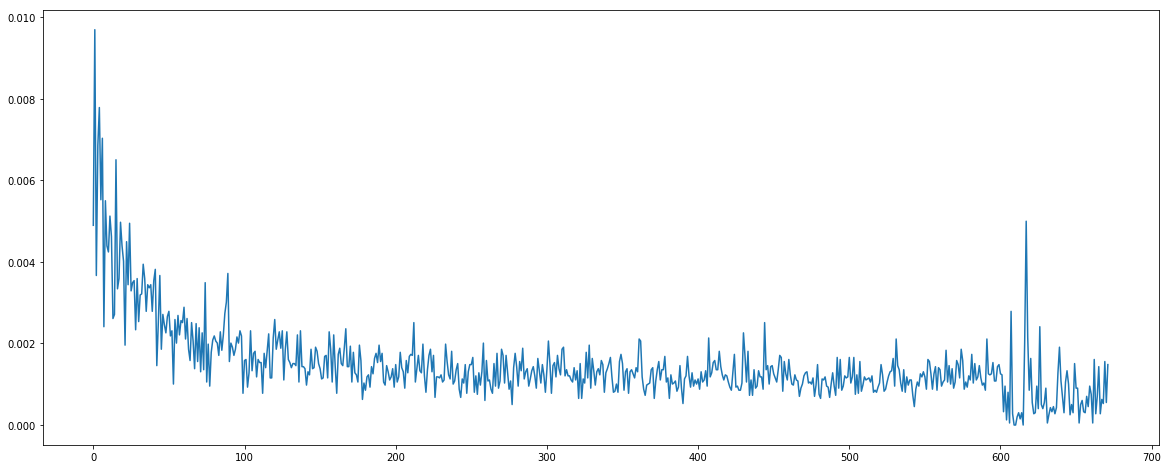

In [42]:
variableImportances.plot(figsize=(20,8))

In [43]:
namedVarImportances = pd.DataFrame({'feature_names': mergedXTrain.columns, 'importance':gbm.feature_importances_})
namedVarImportances[600:]

,feature_names,importance
600,ID,0.001256
601,drugCount,0.001231
602,ingredientCount,0.000327
603,timeCount,0.000954
604,quantitiesCount,0.000126
605,questionMarkCount,0.000804
606,sentenceCount,0.000050
607,wordCount,0.002788
608,combienCount,0.000276
609,pourquoiCount,0.000000


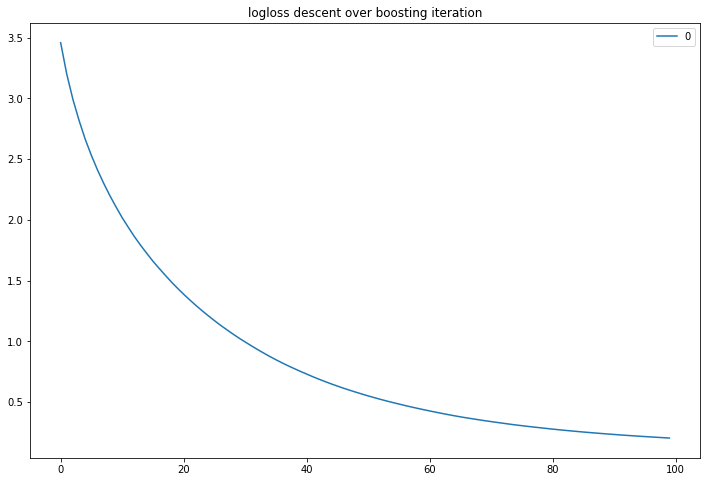

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.DataFrame(gbm.evals_result_.get('validation_0').get('mlogloss')).plot(figsize=(12,8), title='logloss descent over boosting iteration')

In [45]:
YPredicted = gbm.predict(mergedXTest)
YTrue = YTest.intention

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.88      0.43      0.58        35
          1       0.00      0.00      0.00         4
          2       1.00      0.40      0.57         5
          3       0.00      0.00      0.00         1
          4       1.00      0.73      0.84        11
          5       0.43      0.17      0.24        18
          6       1.00      0.50      0.67         4
          7       0.20      1.00      0.33         1
          8       0.78      0.56      0.65        25
          9       0.67      0.29      0.40         7
         10       0.67      0.33      0.44        12
         11       0.38      0.22      0.28        27
         12       0.22      0.33      0.27         6
         13       0.33      0.33      0.33        12
         14       0.50      0.55      0.52        42
         15       0.50      1.00      0.67         4
         16       1.00      0.33      0.50         3
         17       0.00      0.00      0.00   

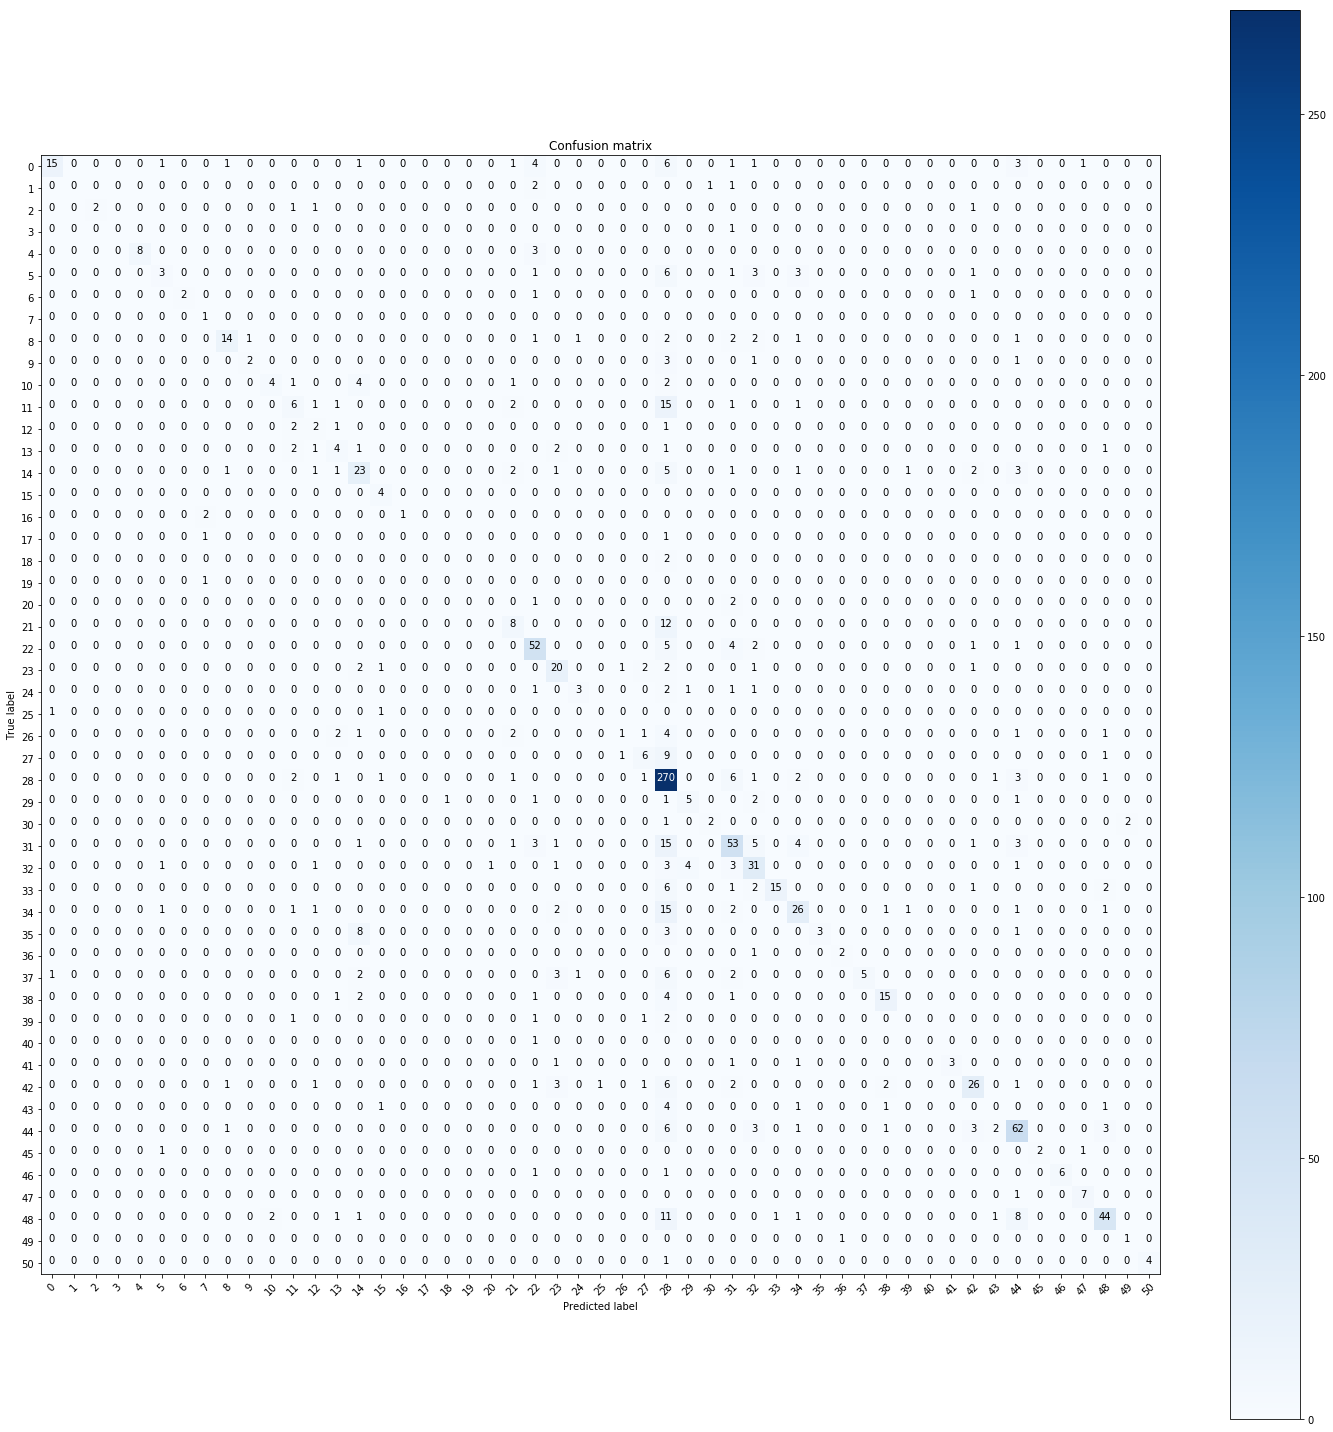

In [46]:

import sys
sys.path.append('..')
from utils import vizu

import sklearn
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()


In [48]:
macroF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='macro')
microF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='micro')
print ("micro F1 score = {:1.4f} ; macro F1 score = {:1.4f}".format(microF1Score, macroF1Score))

micro F1 score = 0.6332 ; macro F1 score = 0.4446


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
